In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from tqdm import tqdm
from PIL import Image
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

def creatModelInstance(output):
    print("Creating Model....")
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    model = models.Sequential()
    inputs = tf.keras.layers.Input((32, 32, 3))
    x = layers.UpSampling2D((2,2))(inputs)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.UpSampling2D((2,2))(x)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(output, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar_model")
    model.summary()
    return model 

In [3]:
model0 = creatModelInstance(5)

Creating Model....
Model: "cifar_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
(trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()
trainY = tf.keras.utils.to_categorical(trainY)
testY = tf.keras.utils.to_categorical(testY)
trainX = trainX/255
testX =testX/255

In [5]:
### Selecting the classes
hold_in_train_class = [0,1,2,3,4]
hold_in_train_class_idx = []
for i in hold_in_train_class:
    hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(trainY,i)
### Selecting the classes
hold_in_test_class = [0,1,2,3,4]
hold_in_test_class_idx = []
for i in hold_in_test_class:
    hold_in_test_class_idx = hold_in_test_class_idx + returnClassIndex(testY,i)

testY0 = keras.utils.to_categorical(np.argmax(testY[hold_in_test_class_idx], axis =1), 
                                    num_classes = 5)
trainY0 = keras.utils.to_categorical(np.argmax(trainY[hold_in_train_class_idx], axis =1), 
                                    num_classes = 5)

In [6]:
testY0.shape

(5000, 5)

In [7]:
batch_size = 16
model0.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', 
              metrics=['acc'])
history = model0.fit(trainX[hold_in_train_class_idx],trainY0,
                     batch_size=batch_size, epochs=3,
                     validation_data = (testX[hold_in_test_class_idx],
                                                        testY0),
                    )

Epoch 1/3
1563/1563 [==============================] - 811s 519ms/step - loss: 0.3794 - acc: 0.5588 - val_loss: 0.1699 - val_acc: 0.8376
Epoch 2/3
1563/1563 [==============================] - 1051s 672ms/step - loss: 0.2492 - acc: 0.7435 - val_loss: 0.1225 - val_acc: 0.8828
Epoch 3/3
1563/1563 [==============================] - 1107s 709ms/step - loss: 0.1946 - acc: 0.8171 - val_loss: 0.0886 - val_acc: 0.9260


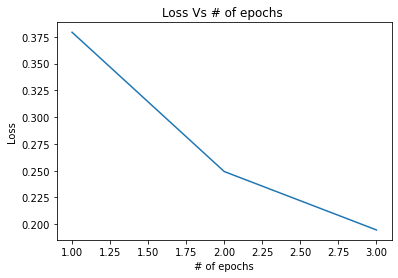

In [8]:
plt.title("Loss Vs # of epochs ")
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(3)+1,history.history['loss'])

## Fine tunning Model

In [9]:
history1 = model0.fit(trainX[hold_in_train_class_idx],trainY0,
                     batch_size=batch_size, epochs=3,
                     validation_data = (testX[hold_in_test_class_idx],
                                                        testY0),
                    )

Epoch 1/3
1563/1563 [==============================] - 1050s 672ms/step - loss: 0.1557 - acc: 0.8676 - val_loss: 0.0854 - val_acc: 0.9198
Epoch 2/3
1563/1563 [==============================] - 1039s 665ms/step - loss: 0.1316 - acc: 0.8926 - val_loss: 0.0626 - val_acc: 0.9472
Epoch 3/3
1563/1563 [==============================] - 964s 617ms/step - loss: 0.1126 - acc: 0.9095 - val_loss: 0.0541 - val_acc: 0.9532


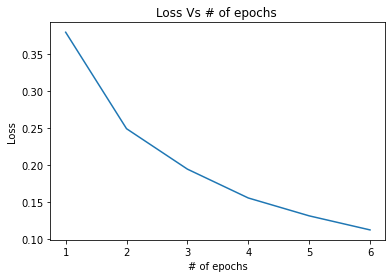

In [10]:
plt.title("Loss Vs # of epochs ")
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(6)+1,list(history.history['loss'])+ list(history1.history['loss']))

In [11]:
print("Evaluating model on Old classes")
scores = model0.evaluate(testX[hold_in_test_class_idx], testY0)

Evaluating model on Old classes
157/157 [==============================] - 53s 336ms/step - loss: 0.0541 - acc: 0.9532


In [12]:
### Selecting the classes
hold_out_test_class = [5,6,7,8,9]
hold_out_test_class_idx = []
for i in hold_out_test_class:
    hold_out_test_class_idx = hold_out_test_class_idx + returnClassIndex(testY,i)
    
testY0_new = keras.utils.to_categorical(np.argmax(testY[hold_out_test_class_idx], 
                                                  axis =1)-5, 
                                        num_classes = 5)

In [13]:
print("Evalauting model on new classes")
scores_new = model0.evaluate(testX[hold_out_test_class_idx], testY0_new)
print("Note performace")

Evalauting model on new classes
157/157 [==============================] - 50s 316ms/step - loss: 1.4209 - acc: 0.0280
Note performace


In [14]:
print("Loading in New class detector...")
with open('Models/binary_classifier_resnet_model1_cifar10.json', 'r') as j_file:
    loaded_model_json = j_file.read()
newclass_detector = tf.keras.models.model_from_json(loaded_model_json)
newclass_detector.load_weights("Models/binary_classifier_resnet_model1_cifar10.h5")
newclass_detector.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                          loss='binary_crossentropy',metrics=['acc']
                         )
print("Done!")

Loading in New class detector...
Done!


In [15]:
print("Detecting New classes") 
print("0 - indicates a unknown classs ")
print("1 - Indicates a Known class")
results = newclass_detector.predict(testX, verbose = 1)
print("Done!")

Detecting New classes
0 - indicates a unknown classs 
1 - Indicates a Known class
313/313 [==============================] - 113s 360ms/step
Done!


In [16]:
print("Extracting new classes from DataStream")
results_ = results.round()
c = [i for i in range(len(results)) if(results_[i] == 0)]
print("Number of new classes is ", len(c))
print("Done!")

Extracting new classes from DataStream
Number of new classes is  4791
Done!


## Creating New Model Instance

In [17]:
### Selecting the classes
hold_in_test_class1 = [5,6,7,8,9]
hold_in_test_class_idx1 = []
for i in hold_in_test_class1:
    hold_in_test_class_idx1 = hold_in_test_class_idx1 + returnClassIndex(testY,i)

### Selecting the classes
hold_in_train_class1 = [5,6,7,8,9]
hold_in_train_class_idx1 = []
for i in hold_in_train_class1:
    hold_in_train_class_idx1 = hold_in_train_class_idx1 + returnClassIndex(trainY,i)

testY1 = keras.utils.to_categorical(np.argmax(testY[hold_in_test_class_idx1], 
                                                  axis =1)-5, 
                                        num_classes = 5)
trainY1 = keras.utils.to_categorical(np.argmax(trainY[hold_in_train_class_idx1], 
                                                  axis =1)-5, 
                                        num_classes = 5
                                    )

In [18]:
model1 = creatModelInstance(5)

Creating Model....
Model: "cifar_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 

In [19]:
batch_size = 16
model1.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', 
              metrics=['acc'])
history = model1.fit(trainX[hold_in_train_class_idx1],trainY1,
                     batch_size=batch_size, epochs=6, verbose = 1,
                     validation_data = (testX[hold_in_test_class_idx1],testY1)
                    )

Epoch 1/6
1563/1563 [==============================] - 1001s 640ms/step - loss: 0.3195 - acc: 0.6417 - val_loss: 0.1224 - val_acc: 0.9006
Epoch 2/6
1563/1563 [==============================] - 984s 630ms/step - loss: 0.2021 - acc: 0.8050 - val_loss: 0.0785 - val_acc: 0.9338
Epoch 3/6
1563/1563 [==============================] - 967s 619ms/step - loss: 0.1585 - acc: 0.8628 - val_loss: 0.0581 - val_acc: 0.9580
Epoch 4/6
1563/1563 [==============================] - 949s 607ms/step - loss: 0.1288 - acc: 0.8953 - val_loss: 0.0449 - val_acc: 0.9634
Epoch 5/6
1563/1563 [==============================] - 945s 604ms/step - loss: 0.1056 - acc: 0.9196 - val_loss: 0.0355 - val_acc: 0.9732
Epoch 6/6
1563/1563 [==============================] - 934s 598ms/step - loss: 0.0889 - acc: 0.9348 - val_loss: 0.0329 - val_acc: 0.9730


In [20]:
model1.evaluate((testX[hold_in_test_class_idx1],testY1))

157/157 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


[0.0, 0.0]

In [21]:
tmpX = np.vstack([trainX[hold_in_train_class_idx1], testX[hold_in_test_class_idx1][:50]])
tmpY = np.vstack([trainY[hold_in_train_class_idx1], testY1[hold_in_test_class_idx1][:50]])
history = model1.fit(tmpX,tmpY, batch_size=batch_size, epochs=6, verbose = 1,
                     validation_data = (testX[hold_in_test_class_idx1][50:],testY1[50:])
                    )

IndexError: index 5005 is out of bounds for axis 0 with size 5000

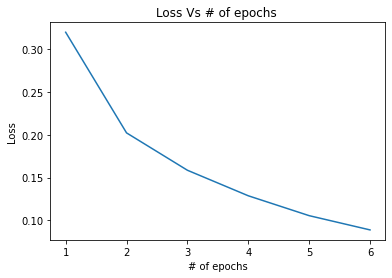

In [22]:
plt.title("Loss Vs # of epochs ")
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(6)+1,history.history['loss'])

In [23]:
print("Performing predictions...")
results1 = model1.predict(testX[c], verbose = 1)
print("Extracting indexes Misclassified prediction due model integration")
tmp = np.argmax(testY[c], axis = 1)
d = [i for i in range(len(tmp)) if (tmp[i] >=5)]
print("A {}% error is introduced as a consequcent of cacding the models".
      format(round(((len(tmp)-len(d))/len(tmp) *100), 3)))
testY__ = tf.keras.utils.to_categorical(
    np.clip(np.absolute(np.argmax(testY[c], axis = 1)-5), 0,4))
print("Evaluating model on new class!")
scores1 = model1.evaluate(testX[c],testY__, verbose = 1)
print("Done!")

Performing predictions...
150/150 [==============================] - 56s 375ms/step
Extracting indexes Misclassified prediction due model integration
A 3.674% error is introduced as a consequcent of cacding the models
Evaluating model on new class!
150/150 [==============================] - 35s 236ms/step - loss: 0.0623 - acc: 0.9537
Done!


In [24]:
from sklearn.metrics import accuracy_score, log_loss, roc_curve, f1_score 
from sklearn.metrics import recall_score, precision_score
p1_= np.argmax(results1, axis =1 ) 
t1_=  np.argmax(testY__, axis = 1)
acc1 = accuracy_score(t1_, p1_)
f1_1 = f1_score(t1_, p1_, average = "macro")
recall_1 = recall_score(t1_, p1_,   average = "macro")
precision_1 =precision_score(t1_, p1_, average = "macro")


#print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc1))
print("F1 Score: {}".format(f1_1))
print("recall Score: {}".format(recall_1))
print("Precision Score: {}".format(precision_1))

Accuracy: 0.9536631183469004
F1 Score: 0.953534686428309
recall Score: 0.95461526253494
Precision Score: 0.953610536709663


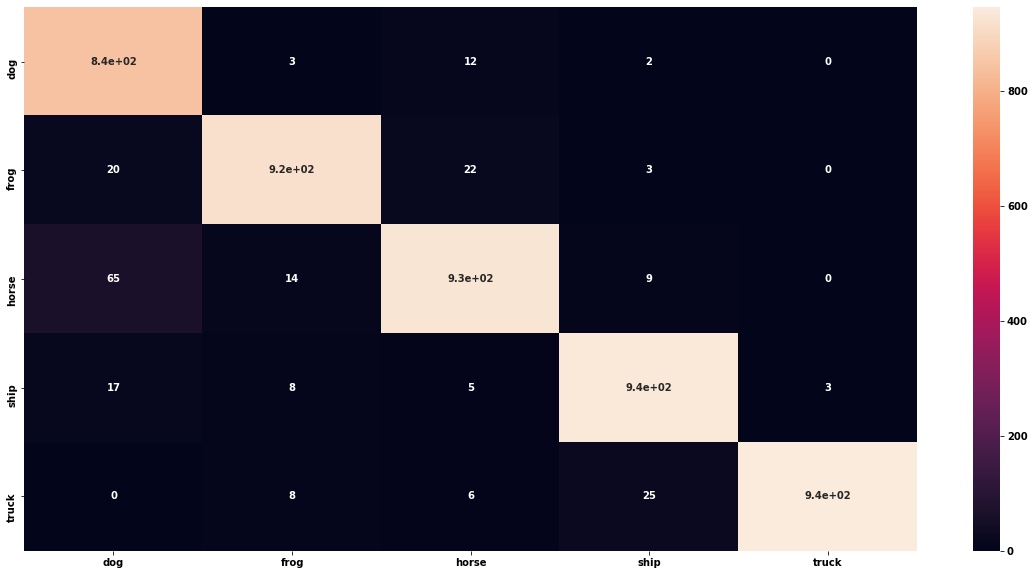

In [25]:
import matplotlib
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

conf = tf.math.confusion_matrix(t1_,p1_)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = ['dog','frog','horse','ship',
               'truck']
df_cm = pd.DataFrame(np.array(conf), index = labels_names,
                  columns =  labels_names)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('saveed_figures/cifar/fadlconf1Cifar10 old Classes.png', dpi =200)
plt.savefig('saveed_figures/cifar/fadlconf1Cifar10 old Classes.pdf', dpi = 200)

<ipython-input-26-f7e90b328e06>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


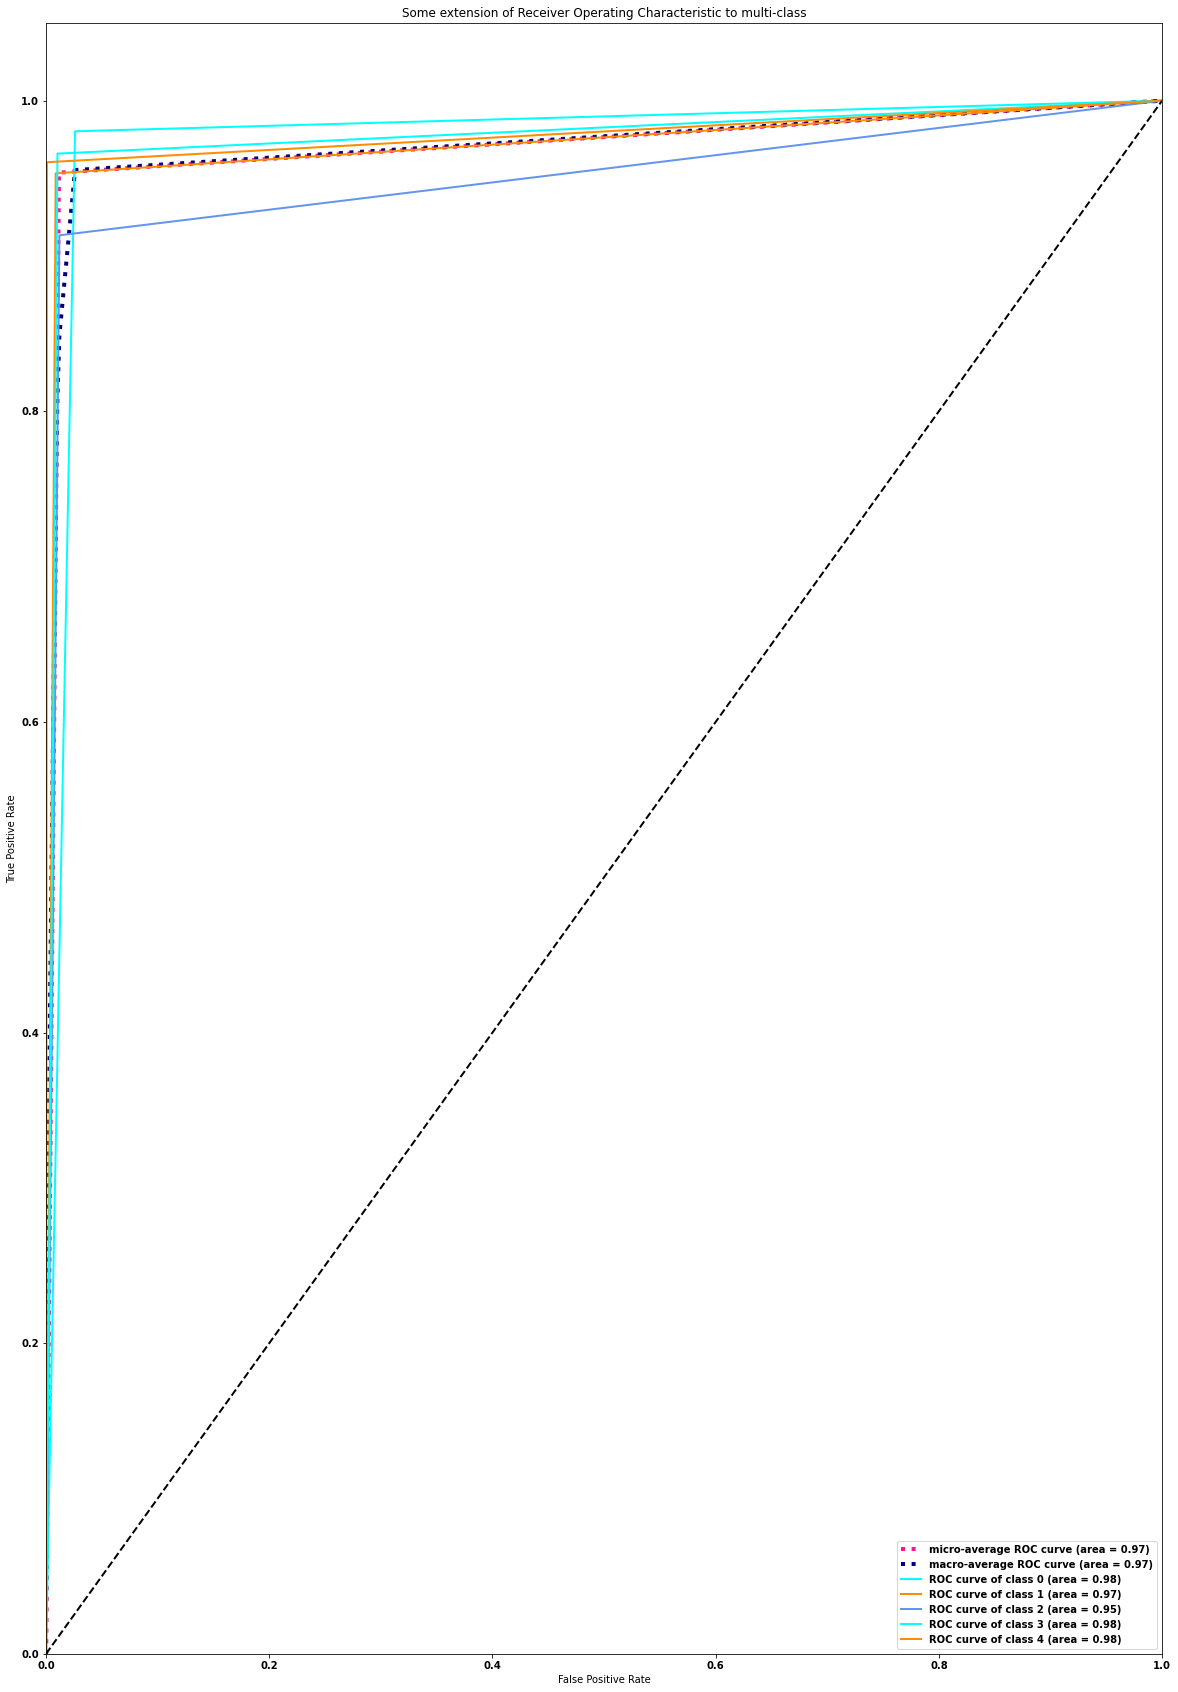

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(t1_))
y_score = np.copy(tf.keras.utils.to_categorical(p1_))
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('saveed_figures/cifar/fadlroc1Cifar10 old Classes.png', dpi = 200)
plt.savefig('saveed_figures/cifar/fadlroc1Cifar10 old Classes.pdf', dpi = 200)
plt.show()

In [27]:
## Known class
c1 = [i for i in range(len(results)) if(results_[i] == 1)]
tmp0 = np.argmax(testY[c1], axis = 1)
print("Performing predictions...")
results0 = model0.predict(testX[c1], verbose = 1)
print("Extracting indexes Misclassified prediction due model integration")
d0 = [i for i in range(len(tmp0)) if (tmp0[i] >=5)]
print("A {}% error is introduced as a consequcent of cascading the models".
      format(round(((len(d0))/len(tmp0) *100), 3)))
tmp0[d0] = 4
testY0__ = tf.keras.utils.to_categorical(tmp0)
print("Evaluating model on new class!")
scores1 = model0.evaluate(testX[c1],testY0__, verbose = 1)
print("Done!")

Performing predictions...
163/163 [==============================] - 89s 548ms/step
Extracting indexes Misclassified prediction due model integration
A 7.391% error is introduced as a consequcent of cascading the models
Evaluating model on new class!
163/163 [==============================] - 47s 286ms/step - loss: 0.1325 - acc: 0.8963
Done!


In [28]:
from sklearn.metrics import accuracy_score, log_loss, roc_curve, f1_score 
from sklearn.metrics import recall_score, precision_score
print("Evaluating model on new class!")
p0_= np.argmax(results0, axis =1 ) 
t0_=  np.argmax(testY0__, axis = 1)
acc0 = accuracy_score(t0_, p0_)
f1_0 = f1_score(t0_, p0_, average = "macro")
recall_0 = recall_score(t0_, p0_,   average = "macro")
precision_0 =precision_score(t0_, p0_, average = "macro")

loss = log_loss( np.copy(tf.keras.utils.to_categorical(t0_)),
                np.copy(tf.keras.utils.to_categorical(p0_)))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc0))
print("F1 Score: {}".format(f1_0))
print("recall Score: {}".format(recall_0))
print("Precision Score: {}".format(precision_0))
print("Done!")

Evaluating model on new class!
Loss: 3.5805220300942104
Accuracy: 0.8963332693415242
F1 Score: 0.8984859634353473
recall Score: 0.9086845838096856
Precision Score: 0.8956369975135475
Done!


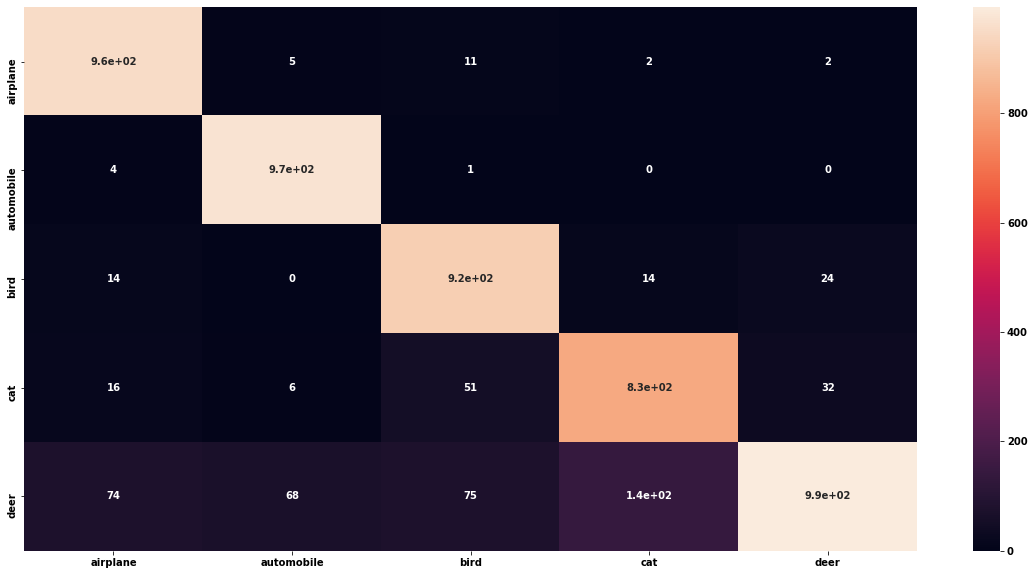

In [29]:
import matplotlib
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

conf = tf.math.confusion_matrix(t0_,p0_)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = ['airplane','automobile','bird','cat','deer']
df_cm = pd.DataFrame(np.array(conf), index = labels_names,
                  columns =  labels_names)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('saveed_figures/cifar/fadlconf1Cifar10 old Classes.png', dpi =200)
plt.savefig('saveed_figures/cifar/fadlconf1Cifar10 old Classes.pdf', dpi = 200)

<ipython-input-30-71804bec6a22>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


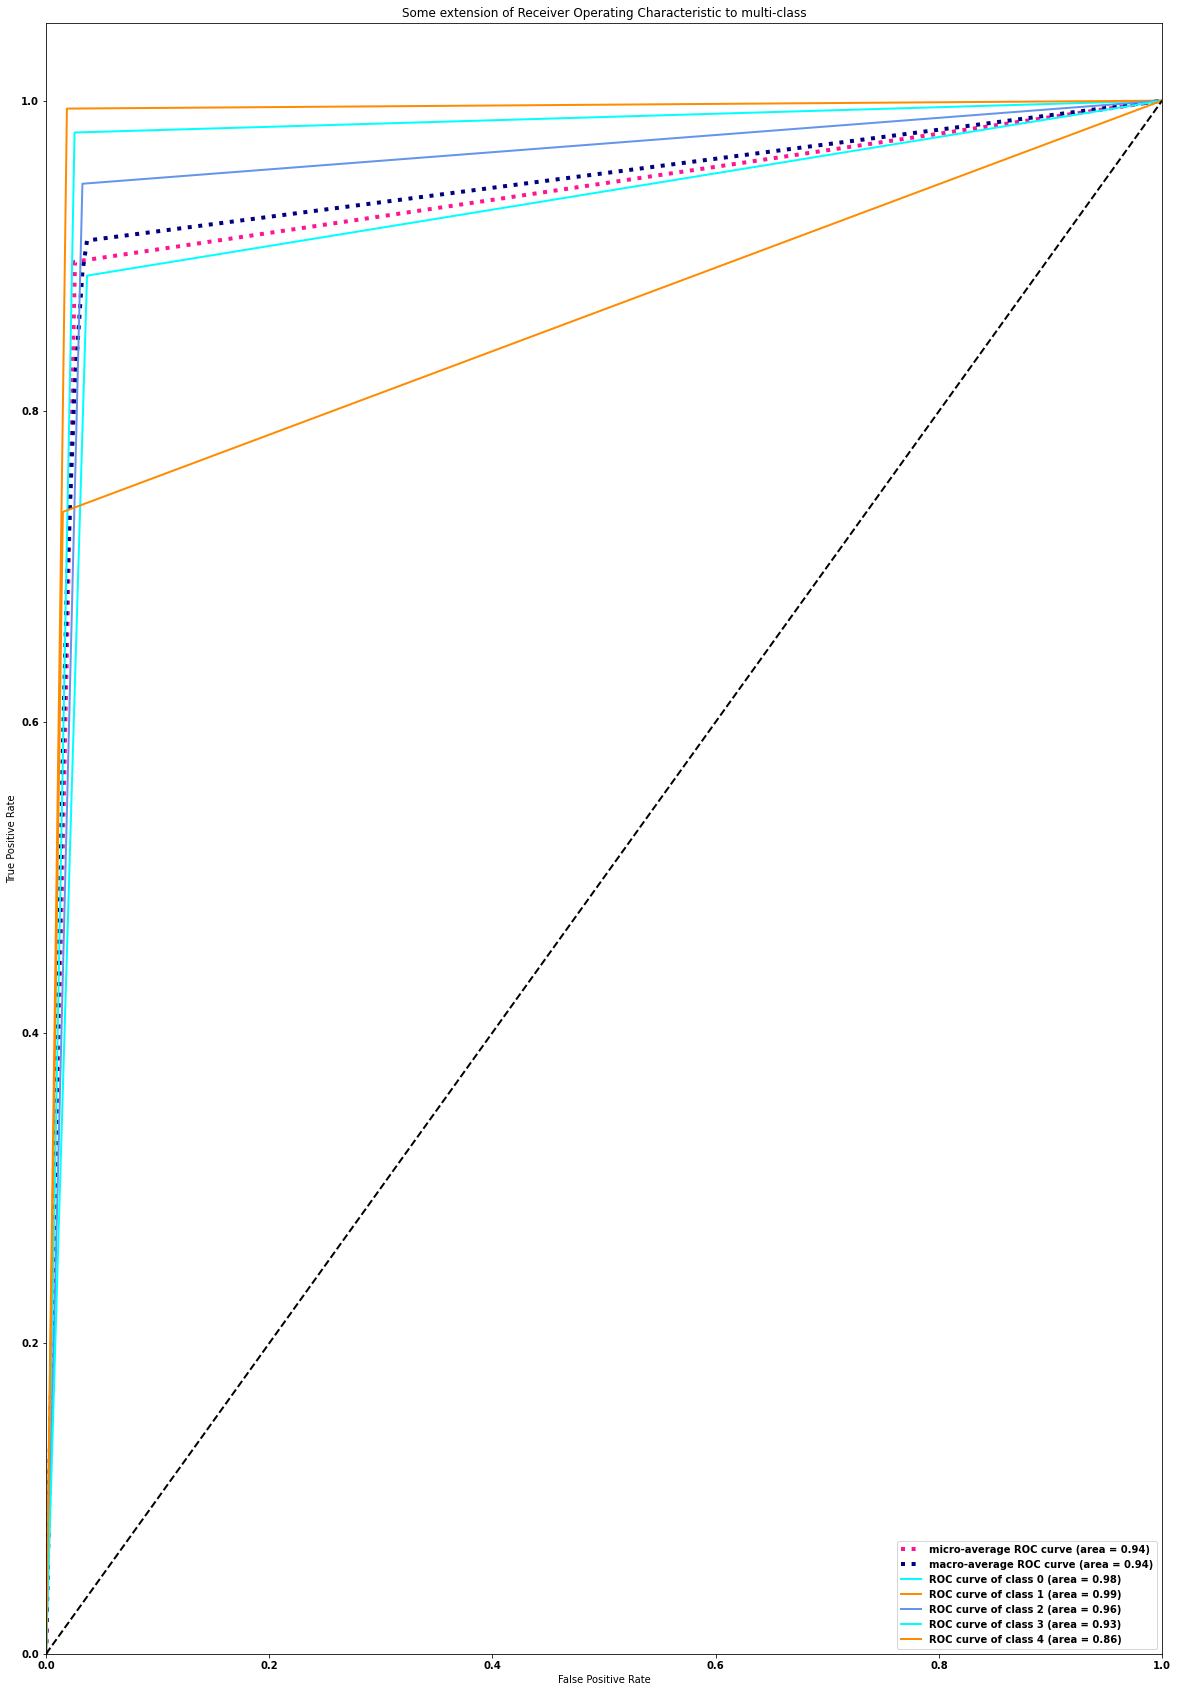

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(t0_))
y_score = np.copy(tf.keras.utils.to_categorical(p0_))
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('saveed_figures/cifar/fadlroc1Cifar10 New Classes.png', dpi = 200)
plt.savefig('saveed_figures/cifar/fadlroc1Cifar10 New Classes.pdf', dpi = 200)
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model0, to_file='known_classes_model_instance.png')

# Serialize model to JSON
model_json = model0.to_json()
with open("Models/known_classes_model_instance.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model1.save_weights("Models/known_classes_model_instance.h5")
print("Saved model to disk")

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='unknown_classes_model_instance.png')

# Serialize model to JSON
model_json = model1.to_json()
with open("Models/unknown_classes_model_instance.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model1.save_weights("Models/unknown_classes_model_instance.h5")
print("Saved model to disk")